# Ensemble classification model in earthquake building damage level detection

# Importing Libraries

In [ ]:
!pip install xgboost
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 115 kB/s 


In [ ]:
import numpy as np
import pandas as pd
import cv2

from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from google.colab import drive

import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb

# Data Loading

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/train_values.csv", index_col='building_id')

In [ ]:
X.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
Y= pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/train_labels.csv", index_col='building_id')

In [ ]:
Y.head()

,damage_grade
building_id,
802906,3
28830,2
94947,3
590882,2
201944,3


In [ ]:
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/test_values.csv", index_col='building_id')

In [ ]:
X.describe()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
count,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,...,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,0.034332,...,0.064378,0.033626,0.008101,0.000940,0.000361,0.001071,0.000188,0.000146,0.000088,0.005119
std,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,0.182081,...,0.245426,0.180265,0.089638,0.030647,0.018989,0.032703,0.013711,0.012075,0.009394,0.071364
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Feature Engineering : Conditional Probabilities of geo_levels

#### ID-1

In [ ]:
fea = pd.merge(X, Y, on='building_id')

In [ ]:
#this block of code calculates the probabilities
damage1 = {}
damage2 = {}
damage3 = {}

for i,j in (X['geo_level_1_id'].value_counts()).iteritems():
    
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_1_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_1_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_1_id']==i])

    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# this block of code appends a new column/feature of probabilities
list1 = []
list2 = []
list3 = []

for i in X['geo_level_1_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

X['prob1_geo1'] = list1
X['prob2_geo1'] = list2
X['prob3_geo1'] = list3

In [ ]:
list1 = []
list2 = []
list3 = []

for i in test['geo_level_1_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

test['prob1_geo1'] = list1
test['prob2_geo1'] = list2
test['prob3_geo1'] = list3

#### ID-2

In [ ]:
damage1 = {}
damage2 = {}
damage3 = {}

for i,j in ((X['geo_level_2_id'].value_counts()).iteritems()):
    
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_2_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_2_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_2_id']==i])

    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [ ]:
list1 = []
list2 = []
list3 = []

for i in X['geo_level_2_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

X['prob1_geo2'] = list1
X['prob2_geo2'] = list2
X['prob3_geo2'] = list3

In [ ]:
list1 = []
list2 = []
list3 = []

for i in test['geo_level_2_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

test['prob1_geo2'] = list1
test['prob2_geo2'] = list2
test['prob3_geo2'] = list3

#### ID-3

In [ ]:
damage1 = {}
damage2 = {}
damage3 = {}

for i,j in ((X['geo_level_3_id'].value_counts()).iteritems()):
    
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_3_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_3_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_3_id']==i])

    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [ ]:
list1 = []
list2 = []
list3 = []

for i in X['geo_level_3_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

X['prob1_geo3'] = list1
X['prob2_geo3'] = list2
X['prob3_geo3'] = list3

In [ ]:
list1 = []
list2 = []
list3 = []

for i in test['geo_level_3_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

test['prob1_geo3'] = list1
test['prob2_geo3'] = list2
test['prob3_geo3'] = list3

# Feature Engineering: Finding relation between geo_levels using seq_to_seq method (LSTM)

<font size=2> **Below is just an example to show how the geo_levels might be related in some way to each other.**
**For geo_level_1 = 6 and geo_level_2=487 we see there are a lot of same geo_levels-3 indicating that there is some relation between these levels.**</font>

In [ ]:
pd.DataFrame(X['geo_level_3_id'][X['geo_level_2_id']==487][X['geo_level_1_id']==6]).head(50)

,geo_level_3_id
building_id,
802906,12198
959468,12198
410679,7439
423950,7439
215003,12198
594969,835
695349,2908
869506,7439
141511,382


### Converting the geo_levels 1 and 2 into one hot encoder with shared vocabulary

In [ ]:
l1 = pd.concat([X['geo_level_1_id'], test['geo_level_1_id']])
l2 = pd.concat([X['geo_level_2_id'], test['geo_level_2_id']])
l3 = pd.concat([X['geo_level_3_id'], test['geo_level_3_id']])

In [ ]:
#get shared vocab of l1 and l2
inp = pd.concat([l1,l2]).to_numpy().reshape(-1,1)

In [ ]:
l1 = pd.concat([X['geo_level_1_id'], test['geo_level_1_id']]).to_numpy().reshape(-1,1)

In [ ]:
l2 = pd.concat([X['geo_level_2_id'], test['geo_level_2_id']]).to_numpy().reshape(-1,1)

In [ ]:
onehot = OneHotEncoder(sparse=False)

In [ ]:
onehot.fit(inp)

OneHotEncoder(sparse=False)

In [ ]:
inp.shape

(694938, 1)

In [ ]:
onehot.categories_

[array([   0,    1,    2, ..., 1425, 1426, 1427])]

In [ ]:
l1_hot = onehot.transform(l1)

In [ ]:
l1_hot.shape

(347469, 1419)

In [ ]:
l2_hot = onehot.transform(l2)

In [ ]:
l2_hot.shape

(347469, 1419)

In [ ]:
fin_inp = np.stack((l1_hot,l2_hot), axis=1)
fin_inp.shape

(347469, 2, 1419)

### Converting geo_level_3 into onehot

In [ ]:
l3_hot = np.array(pd.get_dummies(l3))

In [ ]:
l3_hot.shape

(347469, 11861)

### Creating a LSTM model to get relation features.

In [ ]:
inpx = Input( shape=fin_inp.shape[1:] )  

lstm = LSTM(20, )(inpx)

lvl3 = Dense(l3_hot.shape[1], activation='sigmoid')(lstm)

modelf = Model(inputs= inpx, outputs=lvl3)

modelf.compile(loss='binary_crossentropy', optimizer='adam')

modelf.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 1419)]         0         
                                                                 
 lstm (LSTM)                 (None, 20)                115200    
                                                                 
 dense (Dense)               (None, 11861)             249081    
                                                                 
Total params: 364,281
Trainable params: 364,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelf.fit(fin_inp, l3_hot, epochs=10, batch_size=64)

Epoch 1/10
5430/5430 [==============================] - 28s 4ms/step - loss: 0.0185
Epoch 2/10
5430/5430 [==============================] - 21s 4ms/step - loss: 8.3738e-04
Epoch 3/10
5430/5430 [==============================] - 21s 4ms/step - loss: 8.3149e-04
Epoch 4/10
5430/5430 [==============================] - 21s 4ms/step - loss: 8.3099e-04
Epoch 5/10
5430/5430 [==============================] - 21s 4ms/step - loss: 8.3002e-04
Epoch 6/10
5430/5430 [==============================] - 22s 4ms/step - loss: 7.9931e-04
Epoch 7/10
5430/5430 [==============================] - 21s 4ms/step - loss: 7.5865e-04
Epoch 8/10
5430/5430 [==============================] - 20s 4ms/step - loss: 7.3129e-04
Epoch 9/10
5430/5430 [==============================] - 21s 4ms/step - loss: 7.0694e-04
Epoch 10/10
5430/5430 [==============================] - 21s 4ms/step - loss: 6.8336e-04


### Getting the relation vector from the output of intermediate layer

In [ ]:
inter = Model(inputs=modelf.input, outputs=modelf.layers[1].output)

<font size=3>**Train**</font>

In [ ]:
l1 = X['geo_level_1_id'].to_numpy().reshape(-1,1)

l2 = X['geo_level_2_id'].to_numpy().reshape(-1,1)

In [ ]:
l1_hot = onehot.transform(l1)
l2_hot = onehot.transform(l2)


In [ ]:
fin_inp = np.stack((l1_hot,l2_hot), axis=1)
fin_inp.shape

(260601, 2, 1419)

In [ ]:
geo_fea_train = inter.predict(fin_inp)

<font size=3>**Test**</font>

In [ ]:
l1 = test['geo_level_1_id'].to_numpy().reshape(-1,1)

l2 = test['geo_level_2_id'].to_numpy().reshape(-1,1)

In [ ]:
l1_hot = onehot.transform(l1)
l2_hot = onehot.transform(l2)


In [ ]:
fin_inp = np.stack((l1_hot,l2_hot), axis=1)
fin_inp.shape

(86868, 2, 1419)

In [ ]:
geo_fea_test = inter.predict(fin_inp)

# Final  Data

In [ ]:
print("train {}, test {}  ".format(geo_fea_train.shape, geo_fea_test.shape))

train (260601, 20), test (86868, 20)  


### Preprocessing the data with pd.get_dummies and adding the relation features

In [ ]:
fx_tr = np.hstack((np.array(pd.get_dummies(X.copy().drop(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id'], axis=1))),
                   geo_fea_train))

In [ ]:
fx_tr

array([[ 2.        , 30.        ,  6.        , ...,  0.96285909,
         0.81577134, -0.96272147],
       [ 2.        , 10.        ,  8.        , ...,  0.962865  ,
         0.96268505, -0.96276128],
       [ 2.        , 10.        ,  5.        , ...,  0.96201956,
        -0.96242809, -0.96252221],
       ...,
       [ 3.        , 55.        ,  6.        , ...,  0.9625935 ,
        -0.9607054 , -0.96205711],
       [ 2.        , 10.        , 14.        , ...,  0.96284658,
        -0.96262437, -0.96301383],
       [ 3.        , 10.        ,  7.        , ...,  0.96202922,
        -0.96238035, -0.9625417 ]])

In [ ]:
fx_tr.shape

(260601, 94)

In [ ]:
test.fillna(value=0, inplace=True)

In [ ]:
fx_te = np.hstack((np.array(pd.get_dummies(test.copy().drop(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id'], axis=1))), geo_fea_test))

fx_te.shape

(86868, 94)

In [ ]:
fy_tr = Y.to_numpy().ravel()
fy_tr.shape

(260601,)

# Research hyperparameters

In [ ]:
#input best params here from randm.best_params_
modelrandonforest = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

modelrandonforest = GridSearchCV(estimator=modelrandonforest, param_grid=param_grid, cv=2, scoring='f1_micro', verbose=10)
modelrandonforest.fit(fx_tr, fy_tr)

predsrandon=modelrandonforest.predict(fx_tr)

#f1 score is the metric used in the competition
accuracy1=f1_score(fy_tr,predsrandon,average='micro')
print("Score on test set")
print("\n ========================================================")
print(accuracy1)

Fitting 2 folds for each of 60 candidates, totalling 120 fits
[CV 1/2; 1/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=200
[CV 1/2; 1/60] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.726 total time=  18.2s
[CV 2/2; 1/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=200
[CV 2/2; 1/60] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.727 total time=  18.7s
[CV 1/2; 2/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=500
[CV 1/2; 2/60] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500;, score=0.726 total time=  45.1s
[CV 2/2; 2/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=500
[CV 2/2; 2/60] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500;, score=0.727 total time=  45.2s
[CV 1/2; 3/60] START criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200
[CV 1/2; 3/60] END criterion=gini, max_d

In [ ]:
modelrandonforest.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 500}

In [ ]:
#input best params here from randm.best_params_
modellgb = lgb.LGBMClassifier(random_seed=42, silent=True)

parameters = {
    'n_estimators': [100],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,20,25],
    'num_leaves': [50, 100, 200],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'min_split_gain': [0.3, 0.4],
    'subsample': [0.7, 0.8, 0.9],
    'subsample_freq': [20]
}
modellgb = GridSearchCV(estimator=modellgb, param_grid = parameters,cv = 2, scoring='f1_micro', verbose=10)
modellgb.fit(fx_tr, fy_tr)

predsllgb=modellgb.predict(fx_tr)


#f1 score is the metric used in the competition
accuracy1=f1_score(fy_tr,predsllgb,average='micro')
print("Score on test set")
print("\n ========================================================")
print(accuracy1)

Fitting 2 folds for each of 972 candidates, totalling 1944 fits
[CV 1/2; 1/972] START colsample_bytree=0.7, max_depth=15, min_split_gain=0.3, n_estimators=100, num_leaves=50, reg_alpha=1.1, reg_lambda=1.1, subsample=0.7, subsample_freq=20
[CV 1/2; 1/972] END colsample_bytree=0.7, max_depth=15, min_split_gain=0.3, n_estimators=100, num_leaves=50, reg_alpha=1.1, reg_lambda=1.1, subsample=0.7, subsample_freq=20;, score=0.761 total time=   4.1s
[CV 2/2; 1/972] START colsample_bytree=0.7, max_depth=15, min_split_gain=0.3, n_estimators=100, num_leaves=50, reg_alpha=1.1, reg_lambda=1.1, subsample=0.7, subsample_freq=20
[CV 2/2; 1/972] END colsample_bytree=0.7, max_depth=15, min_split_gain=0.3, n_estimators=100, num_leaves=50, reg_alpha=1.1, reg_lambda=1.1, subsample=0.7, subsample_freq=20;, score=0.761 total time=   4.0s
[CV 1/2; 2/972] START colsample_bytree=0.7, max_depth=15, min_split_gain=0.3, n_estimators=100, num_leaves=50, reg_alpha=1.1, reg_lambda=1.1, subsample=0.8, subsample_freq=20

In [ ]:
modellgb.best_params_

{'colsample_bytree': 0.7,
 'max_depth': 20,
 'min_split_gain': 0.3,
 'n_estimators': 100,
 'num_leaves': 100,
 'reg_alpha': 1.2,
 'reg_lambda': 1.2,
 'subsample': 0.9,
 'subsample_freq': 20}

In [ ]:
#input best params here from randm.best_params_
modelextratrees = ExtraTreesClassifier(random_state=42)

param_grid = {  
    "n_estimators": [360,500],
    "max_depth": [4,5,6,7,8,25,30,32] 
}

modelextratrees = GridSearchCV(estimator=modelextratrees, param_grid=param_grid, cv=2, scoring='f1_micro', verbose=10)
modelextratrees.fit(fx_tr, fy_tr)

predsextra=modelextratrees.predict(fx_tr)

#f1 score is the metric used in the competition
accuracy1=f1_score(fy_tr,predsextra,average='micro')
print("Score on test set")
print("\n ========================================================")
print(accuracy1)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV 1/2; 1/16] START max_depth=4, n_estimators=360..............................
[CV 1/2; 1/16] END max_depth=4, n_estimators=360;, score=0.714 total time=  28.3s
[CV 2/2; 1/16] START max_depth=4, n_estimators=360..............................
[CV 2/2; 1/16] END max_depth=4, n_estimators=360;, score=0.713 total time=  28.6s
[CV 1/2; 2/16] START max_depth=4, n_estimators=500..............................
[CV 1/2; 2/16] END max_depth=4, n_estimators=500;, score=0.715 total time=  39.4s
[CV 2/2; 2/16] START max_depth=4, n_estimators=500..............................
[CV 2/2; 2/16] END max_depth=4, n_estimators=500;, score=0.714 total time=  39.9s
[CV 1/2; 3/16] START max_depth=5, n_estimators=360..............................
[CV 1/2; 3/16] END max_depth=5, n_estimators=360;, score=0.723 total time=  33.6s
[CV 2/2; 3/16] START max_depth=5, n_estimators=360..............................
[CV 2/2; 3/16] END max_depth=5, n_estimator

In [ ]:
modelextratrees.best_params_

{'max_depth': 25, 'n_estimators': 500}

In [ ]:
modelgradient = GradientBoostingClassifier(random_state=42)

param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.15, 0.2],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "subsample":[0.5, 0.618,0.85],
    "n_estimators":[200,400]
    }

modelgradient = GridSearchCV(estimator=modelgradient, param_grid=param_grid, cv=2, scoring='f1_micro', verbose=10)
modelgradient.fit(fx_tr, fy_tr)

predsgradient=modelgradient.predict(fx_tr)

#f1 score is the metric used in the competition
accuracy1=f1_score(fy_tr,predsgradient,average='micro')
print("Score on test set")
print("\n ========================================================")
print(accuracy1)

Fitting 2 folds for each of 144 candidates, totalling 288 fits
[CV 1/2; 1/144] START learning_rate=0.01, loss=deviance, max_depth=3, max_features=log2, n_estimators=200, subsample=0.5
[CV 1/2; 1/144] END learning_rate=0.01, loss=deviance, max_depth=3, max_features=log2, n_estimators=200, subsample=0.5;, score=0.728 total time=  43.7s
[CV 2/2; 1/144] START learning_rate=0.01, loss=deviance, max_depth=3, max_features=log2, n_estimators=200, subsample=0.5
[CV 2/2; 1/144] END learning_rate=0.01, loss=deviance, max_depth=3, max_features=log2, n_estimators=200, subsample=0.5;, score=0.730 total time=  44.3s
[CV 1/2; 2/144] START learning_rate=0.01, loss=deviance, max_depth=3, max_features=log2, n_estimators=200, subsample=0.618
[CV 1/2; 2/144] END learning_rate=0.01, loss=deviance, max_depth=3, max_features=log2, n_estimators=200, subsample=0.618;, score=0.729 total time=  48.1s
[CV 2/2; 2/144] START learning_rate=0.01, loss=deviance, max_depth=3, max_features=log2, n_estimators=200, subsamp

In [ ]:
modelgradient.best_params_

{'learning_rate': 0.025,
 'loss': 'deviance',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 400,
 'subsample': 0.85}

# Applying machine learning

In [ ]:
#fitting
rf = RandomForestClassifier(random_state=42,criterion='entropy', max_depth=8, max_features='auto', n_estimators=200)
rf.fit(fx_tr,fy_tr)

#pred
predrf=rf.predict(fx_tr)

#f1 score is the metric used in the competition
f1_random=f1_score(fy_tr,predrf,average='micro')
print("F1 score from Random Forest: ",f1_random)

F1 score from Random Forest:  0.7505228299200694


In [ ]:
#fitting
modellgb = lgb.LGBMClassifier(random_seed=42)
modellgb.fit(fx_tr, fy_tr)

#pred
predslgb = modellgb.predict(fx_tr)

#f1 score is the metric used in the competition
f1_lgb=f1_score(fy_tr,predslgb,average='micro')
print("F1 score from LGBM: ",f1_lgb)

F1 score from LGBM:  0.7663477883814721


In [ ]:
#fitting
modellgb = lgb.LGBMClassifier(colsample_bytree=0.7, max_depth=25, min_split_gain=0.3,
               num_leaves=200, random_seed=42, reg_alpha=1.3, reg_lambda=1.1,
               subsample=0.9, subsample_freq=20)
modellgb.fit(fx_tr, fy_tr)

#pred
predslgb = modellgb.predict(fx_tr)

#f1 score is the metric used in the competition
f1_lgb=f1_score(fy_tr,predslgb,average='micro')
print("F1 score from LGBM: ",f1_lgb)

F1 score from LGBM:  0.7897974297872994


In [ ]:
#fitting
modelextratrees = ExtraTreesClassifier(random_state=42, max_depth = 25, n_estimators = 500)
modelextratrees.fit(fx_tr, fy_tr)

#pred
predsextra=modelextratrees.predict(fx_tr)

#f1 score is the metric used in the competition
f1_extra = f1_score(fy_tr,predsextra,average='micro')
print("F1 score from Extratrees: ",f1_extra)

F1 score from Extratrees:  0.8961899608980779


In [ ]:
#fitting
modelxgb_cl = xgb.XGBClassifier(random_state=42)
modelxgb_cl.fit(fx_tr, fy_tr)

#pred
predsxgb_cl = modelxgb_cl.predict(fx_tr)

#f1 score is the metric used in the competition
f1_xgb=f1_score(fy_tr,predsxgb_cl,average='micro')
print("F1 score from XGB: ",f1_xgb)

F1 score from XGB:  0.7574951746156001


In [ ]:
#fitting
modelxgb_cl = xgb.XGBClassifier(random_state=42,objective='multi:softmax', gamma=0.001369048068388758, eta=0.11,
                  max_depth= 20,
                  min_child_weight=9,
                  num_class= 4,
                  subsample= .85,
                  colsample_bytree= .9, verbose=10)
modelxgb_cl.fit(fx_tr, fy_tr)

#pred
predsxgb_cl = modelxgb_cl.predict(fx_tr)

#f1 score is the metric used in the competition
f1_xgb=f1_score(fy_tr,predsxgb_cl,average='micro')
print("F1 score from XGB: ",f1_xgb)

F1 score from XGB:  0.8722453098798546


In [ ]:
#fitting
modelgradient = GradientBoostingClassifier(random_state=42)
modelgradient.fit(fx_tr, fy_tr)

#pred
predsgradient = modelgradient.predict(fx_tr)

#f1 score is the metric used in the competition
f1_gradient=f1_score(fy_tr,predsgradient,average='micro')
print("F1 score from Gradient Boosting: ",f1_gradient)

F1 score from Gradient Boosting:  0.7606455846293758


In [ ]:
#fitting
modelgradient = GradientBoostingClassifier(random_state=42, learning_rate=0.15,loss='deviance', max_depth=8, max_features='sqrt',n_estimators= 400,subsample=0.85)
modelgradient.fit(fx_tr, fy_tr)

#pred
predsgradient = modelgradient.predict(fx_tr)

#f1 score is the metric used in the competition
f1_gradient=f1_score(fy_tr,predsgradient,average='micro')
print("F1 score from Gradient Boosting: ",f1_gradient)

F1 score from Gradient Boosting:  0.8359100694164643


In [ ]:
#fitting
modelcat = CatBoostClassifier(eval_metric='TotalF1',random_seed=42, silent=True, border_count=13, depth= 10, iterations = 5000, l2_leaf_reg = 3, learning_rate = 0.05)
modelcat.fit(fx_tr, fy_tr)

#pred
predscat=modelcat.predict(fx_tr)

#f1 score is the metric used in the competition
f1_cat=f1_score(fy_tr,predscat,average='micro')
print("F1 score from Cat Boost: ",f1_cat)

F1 score from Cat Boost:  0.8931968795208


In [ ]:
#fitting
modelada = AdaBoostClassifier(random_state=42,base_estimator=None, learning_rate=0.4, n_estimators=190)
modelada.fit(fx_tr, fy_tr)

#pred
predsada=modelada.predict(fx_tr)

#f1 score is the metric used in the competition
f1_ada=f1_score(fy_tr,predsada,average='micro')
print("F1 score from Ada Boost: ",f1_ada)

F1 score from Ada Boost:  0.752138326407036


# Ensemble Classifier - Voting Classifier

In [171]:
%%time

voting_clf = VotingClassifier(estimators=[('rf', rf),
                                          ('lgb',modellgb),
                                          ('gradient',modelgradient),
                                          ('extra',modelextratrees),
                                          ('xbg', modelxgb_cl),
                                          ('cat', modelcat),
                                          ('ada', modelada)], voting='soft', verbose=10)
voting_clf.fit(fx_tr, fy_tr)

[Voting] ....................... (1 of 7) Processing rf, total=  52.9s
[Voting] ...................... (2 of 7) Processing lgb, total=  33.2s
[Voting] ................. (3 of 7) Processing gradient, total= 9.2min
[Voting] .................... (4 of 7) Processing extra, total= 3.8min
[Voting] ...................... (5 of 7) Processing xbg, total=23.4min
[Voting] ...................... (6 of 7) Processing cat, total=16.6min
[Voting] ...................... (7 of 7) Processing ada, total= 2.6min
CPU times: user 2h 22min 47s, sys: 39.9 s, total: 2h 23min 27s
Wall time: 57min 7s


In [172]:
#pred
pred_votting = voting_clf.predict(fx_tr)

#f1 score is the metric used in the competition
f1_votting = f1_score(fy_tr,pred_votting,average='micro')

print("F1 score from Votting: ",f1_votting)

F1 score from Votting:  0.8566812867180095


# Evaluations

In [173]:
probas = [c.predict_proba(fx_tr) for c in (rf, modellgb, modelgradient, modelextratrees, modelxgb_cl, voting_clf)]

In [174]:
class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]
class3_1 = [pr[0, 2] for pr in probas]

In [177]:
df_models = pd.DataFrame(None,columns=["percent","classe"])

for n in class1_1:
  df_class1 = pd.DataFrame([[n, 'class1']], columns=["percent","classe"])
  df_models = pd.concat([df_models, df_class1])

for n in class2_1:
  df_class2 = pd.DataFrame([[n, 'class2']], columns=["percent","classe"])
  df_models = pd.concat([df_models, df_class2])

for n in class3_1:
  df_class3 = pd.DataFrame([[n, 'class3']], columns=["percent","classe"])
  df_models = pd.concat([df_models, df_class3])

df_models["models"] = ['Random Forest', 'LGBM', 'Gradient Boosting', 'Extraa Trees', 'XGB Boosting', 'Votting Classifier',
                      'Random Forest', 'LGBM', 'Gradient Boosting', 'Extraa Trees', 'XGB Boosting', 'Votting Classifier',
                      'Random Forest', 'LGBM', 'Gradient Boosting', 'Extraa Trees', 'XGB Boosting', 'Votting Classifier']

df_models['percent'] = round(df_models.percent,2)

In [179]:
df_models

,percent,classe,models
0,0.00,class1,Random Forest
0,0.00,class1,LGBM
0,0.00,class1,Gradient Boosting
0,0.00,class1,Extraa Trees
0,0.00,class1,XGB Boosting
0,0.03,class1,Votting Classifier
0,0.22,class2,Random Forest
0,0.14,class2,LGBM
0,0.25,class2,Gradient Boosting
0,0.12,class2,Extraa Trees


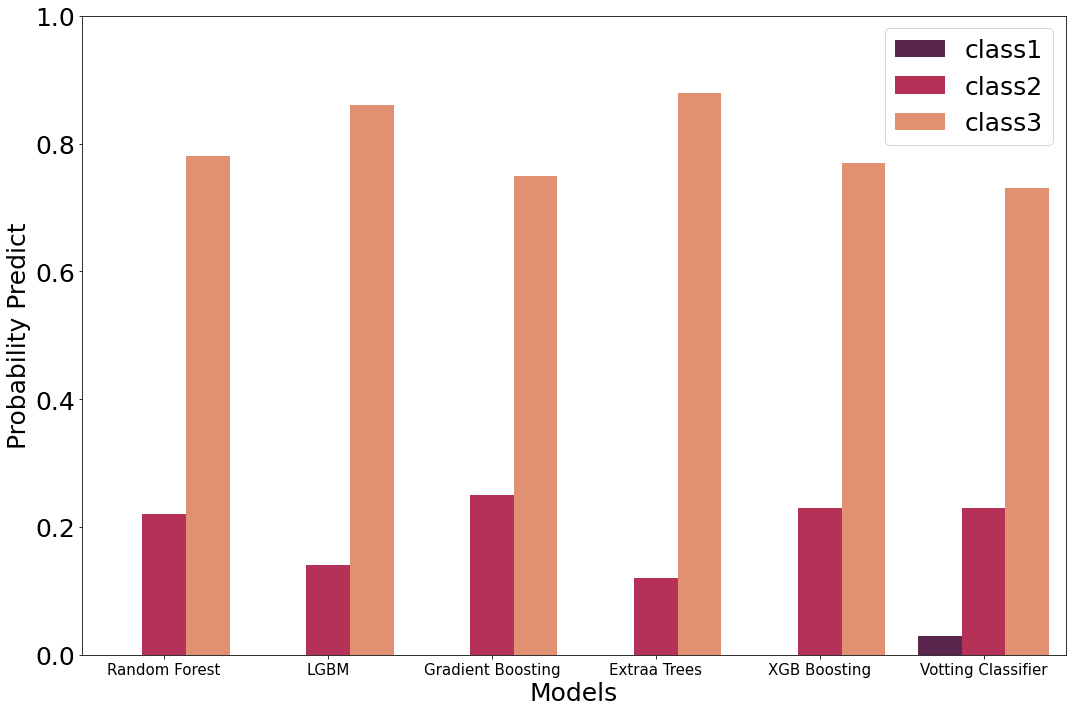

In [178]:
fig, ax = plt.subplots(figsize=(15,10))

sns.color_palette("rocket", as_cmap=True)

sns.barplot(data=df_models, x='models', y='percent', hue='classe', palette='rocket')

plt.ylim([0, 1])
plt.legend(prop={'size': 25})
plt.ylabel('Probability Predict', size=25)
plt.xlabel('Models', size=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

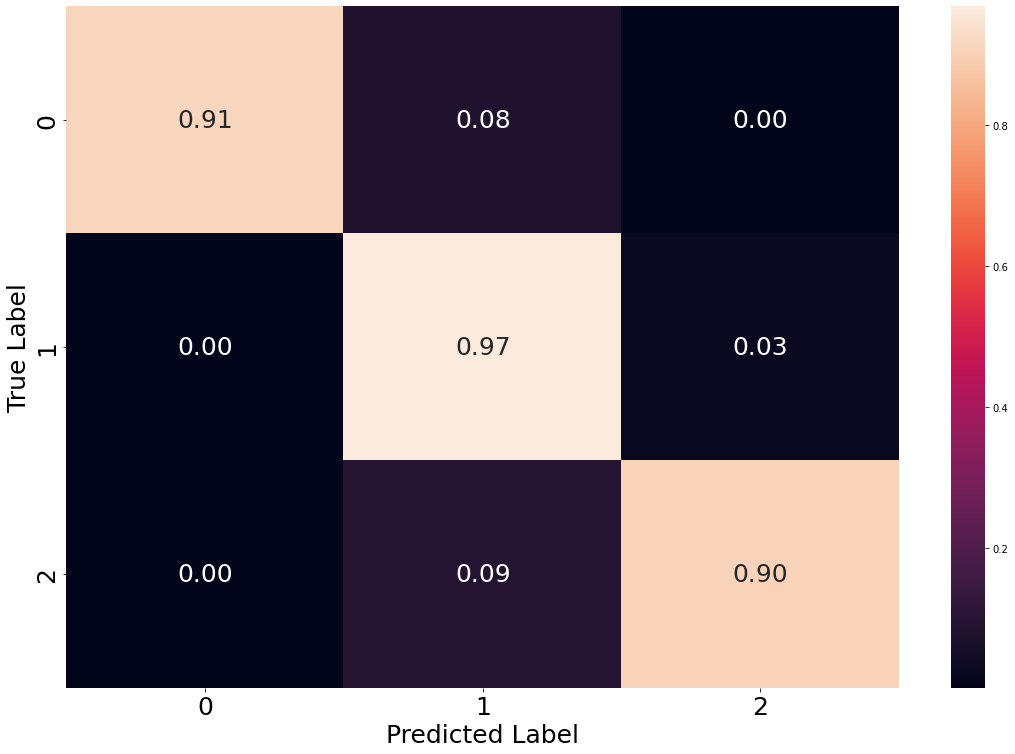

In [ ]:
cm = confusion_matrix(fy_tr, pred_votting, labels=voting_clf.classes_)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(cmn, annot=True, fmt='.2f', annot_kws={'size': 25}, ax=ax)
fig.tight_layout()
plt.ylabel('True Label', size=25)
plt.xlabel('Predicted Label', size=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show(block=False)

# Submit

In [ ]:
pred_votting_base_test = voting_clf.predict(fx_te)

In [ ]:
sub_csv = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/submission_format.csv")

sub_csv["damage_grade"] = pred_votting_base_test
sub_csv.to_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/output/submit/ensemble_feature_engineering_teste_1.csv", index=False)

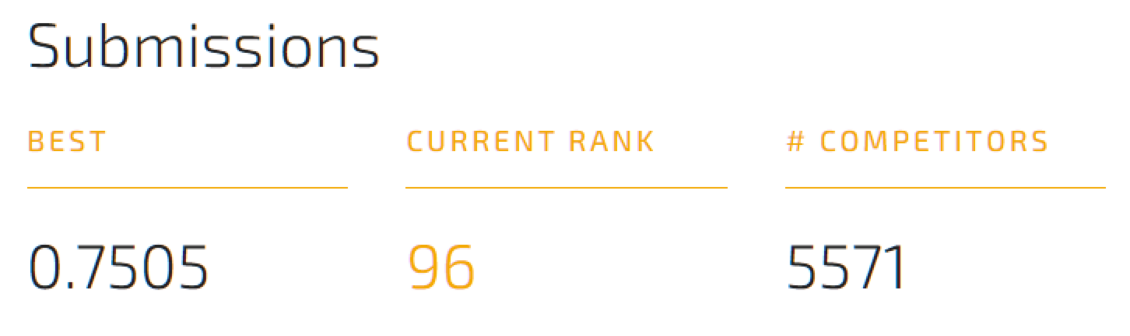

In [ ]:
img = cv2.imread("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/Results.png")

plt.figure(figsize=(20, 16))
plt.imshow(img)
plt.axis('off')
plt.show()